# On Polarized Opinions and Echo Chambers: A Network Analysis of 2022 PH Presidential Election Tweets

In today's digital age, social media has become an indispensable part of our lives, providing instant and cost-effective means to connect, communicate, and stay informed. Platforms like Facebook and Twitter wield immense power in shaping discourse and relationships, especially in the political landscape. With around 90% of Filipinos having internet access and 81% being on Facebook, the Philippines serves as an ideal site to study the mobilization power of these platforms and how they may contribute to the emergence of polarized opinions and potential "echo chambers".

The 2022 Philippine Presidential election holds particular significance for me, as I witnessed firsthand the intense conflicts and unfriending of family and friends due to irreconcilable differences in opinions. It became evident how selective exposure and information filtering influence our thoughts and behavior. While there is public assertion about the influence of social media on election outcomes, I want to conduct a formal study on this matter.

Particularly, I focused on analyzing the impact of polarized political positions on relationship formation, information dissemination, and the potential presence of echo chambers within political communication networks on Twitter during the 2022 Philippine Presidential campaign and election period.

In [1]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter

import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from community import community_louvain
import community

randstate = 143

# Data Loading

In [2]:
fname1 = 'data/before_wsentiment.csv'
fname2 = 'data/during_wsentiment.csv'
fname3 = 'data/after_wsentiment.csv'

# Read all files
df1 = pd.read_csv(fname1, usecols=['Date', 'User', 'Tweet', 'Sentiment'], parse_dates=['Date'])
df2 = pd.read_csv(fname2, usecols=['Date', 'User', 'Tweet', 'Sentiment'], parse_dates=['Date'])
df3 = pd.read_csv(fname3, usecols=['Date', 'User', 'Tweet', 'Sentiment'], parse_dates=['Date'])

# Collate into 1 dataframe
df = pd.concat([df1, df2, df3]).reset_index(drop=True)
df.rename(columns=lambda x: x.lower(), inplace=True)
df.rename(columns={'date': 'datetime'}, inplace=True)

# Add features
df['date'] = df.datetime.dt.date

In [3]:
print(f'Before Election: {df1.Date.min(), df1.Date.max()}')
print(f'During Election: {df2.Date.min(), df2.Date.max()}')
print(f'After Election: {df3.Date.min(), df3.Date.max()}')

Before Election: (Timestamp('2021-02-15 16:55:18+0000', tz='UTC'), Timestamp('2021-10-04 23:23:26+0000', tz='UTC'))
During Election: (Timestamp('2022-05-10 13:10:13+0000', tz='UTC'), Timestamp('2022-05-23 23:54:48+0000', tz='UTC'))
After Election: (Timestamp('2022-09-15 06:14:56+0000', tz='UTC'), Timestamp('2022-11-29 23:14:39+0000', tz='UTC'))


In [4]:
df.head()

datetime          user  \
0 2021-10-04 23:23:26+00:00   adprlaw1987   
1 2021-10-04 22:18:15+00:00      gero_rgo   
2 2021-10-04 21:36:29+00:00       renpos2   
3 2021-10-04 21:12:36+00:00  ronamgavin12   
4 2021-10-04 20:35:16+00:00       rodev10   

                                               tweet sentiment        date  
0  So, what will it be? From the looks of it, and...   neutral  2021-10-04  
1  The Greatest Lesson Bongbong Marcos Learned Fr...  positive  2021-10-04  
2  @inquirerdotnet Question: Has the Marcos famil...  negative  2021-10-04  
3  @bongbongmarcos the OG VP Bongbong…\nsana hind...  positive  2021-10-04  
4  @TVPatrol Delicadeza naman for Bongbong Marcos...  negative  2021-10-04

In [5]:
df.shape, df.drop_duplicates().shape

((15000, 5), (15000, 5))

# Data Preprocessing

In [6]:
def remove_links(tweet):
    # Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
    """
    Remove web links from a given text
    
    Parameters
    ----------
    tweet : string
        Text to be stripped of web links

    Returns
    -------
    tweet : string
        Text without webs links
    """
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    return tweet

def remove_users(tweet):
    # Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
    """
    Remove user account information and retweet tags from a given text
    
    Parameters
    ----------
    tweet : string
        Text to be stripped of web links

    Returns
    -------
    tweet : string
        Text user information and retweet tags
    """
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def clean_tweet(tweet, exclude_words):
    # Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
    """
    Transform a given text into lowercase format, remove any user account
    information, retweet tags, and special characters.
    
    Parameters
    ----------
    tweet : string
        Text to be cleaned and formatted

    Returns
    -------
    tweet : string
        Cleaned text
    """
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet.lower()) # lowercase letters
    tweet = re.sub(fr'[{punctuations}]+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet_tokens = tweet.split(' ') #regex_tokenizer.tokenize(tweet) #
    tweet_tokens = [WordNetLemmatizer().lemmatize(w) for w in tweet_tokens
                        if w not in exclude_words]

    tweet = ' '.join(tweet_tokens)
    return tweet

def text_remove_unicode(text):
    text = re.sub(
        r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?",
        "", text)
    return text

def plot_wordcloud(data_dict, title, img_fname=None):
    """
    Plot a word cloud of a set of input words

    Parameters
    ----------
    data_dict : dict
        Dictionary whose keys are the words, and their frequency as values
        
    title: str
        Title of the figure to plot
    """
    c = Counter(data_dict)
    res = {key: val for key, val in sorted(c.items(), key = lambda ele: ele[1], reverse=True)}
    
    if img_fname is None:
        wordcloud = (WordCloud(background_color ='white', colormap='gist_heat', #'gist_heat'
                               width=1500, height=800,
                               collocations=False, random_state=randstate)
                               .generate_from_frequencies(res))
    else:
        mask_img = np.array(Image.open(img_fname))
        wordcloud = (WordCloud(background_color ='white', colormap='gist_heat', #'gist_heat'
                               width=1500, height=800, mask=mask_img,
                               collocations=False, random_state=randstate)
                               .generate_from_frequencies(res))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    # plt.title(f'Fig. {fig_n}: {title}', fontsize=15)
#     plt.savefig(f'wc_{title}.png', dpi=150, bbox_inches='tight')
    # _ = fig_count()
    plt.show()


class Lemmatizer:
    """Lemmatize text using WordNet"""

    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, text):
        return [
            self.wnl.lemmatize(word)
            for word
            in re.findall(r"(?u)(?<!<)[a-z]{2,}", text)
        ]

# define tagalog stop words and bad words [R]
tl_stopwords= ["pldt","pldtcares","pldthome","akin","aking","ako","alin",
               "am","amin","aming","ang","ano","anumang","apat","at","atin",
               "ating","ay","bababa","bago","bakit","bawat","bilang","dahil",
               "dalawa","dapat","din","dito","doon","gagawin","gayunman",
               "ginagawa","ginawa","ginawang","gumawa","gusto","habang",
               "hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig",
               "ikaw","ilagay","ilalim","ilan","inyong","isa","isang",
               "itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan",
               "kailanman","kami","kanila","kanilang","kanino","kanya",
               "kanyang","kapag","kapwa","karamihan","katiyakan","katulad",
               "kaya","kaysa","ko","kong","kulang","kumuha","kung","laban",
               "lahat","lamang","likod","lima","maaari","maaaring","maging",
               "mahusay","makita","marami","marapat","masyado","may",
               "mayroon","mga","minsan","mismo","mula","muli","na",
               "nabanggit","naging","nagkaroon","nais","nakita","namin",
               "napaka","narito","nasaan","ng","ngayon","ni","nila","nilang",
               "nito","niya","niyang","noon","o","pa","paano","pababa",
               "paggawa","pagitan","pagkakaroon","pagkatapos","palabas",
               "pamamagitan","panahon","pangalawa","para","paraan","pareho",
               "pataas","pero","pumunta","pumupunta","sa","saan","sabi",
               "sabihin","sarili","sila","sino","siya","tatlo","tayo",
               "tulad","tungkol","una","walang", "nyo", "niyo", "naman",
               "mo", "pls", "po", "kayo", "ba", "hi", "hello", "wala", "u",
               "nung", "nang", "kami", "kmi", "amp", "beh", "rin", "din",
               "jusko", "ha", "g", "kasi", "lang", "pi", "nadin", "narin",
               "e", "eh", "nga", "hey", "huy", "kayong", "nag", "paki", "pls",
               "di", "talaga", "si", "kay", "kay", "presidente", "election",
               "philippine", "philippines", "presidential", "yung", "yan",
               "like", "nya", "mag", "also", "daw", "pag", "de", "yun"]

tl_badwords = ["amputa","animal ka","bilat","binibrocha","bobo","bogo",
               "boto","brocha","burat","bwesit","bwisit","demonyo ka",
               "engot","etits","gaga","gagi","gago","habal","hayop ka",
               "hayup","hinampak","hinayupak","hindot","hindutan","hudas",
               "iniyot","inutel","inutil","iyot","kagaguhan","kagang",
               "kantot","kantotan","kantut","kantutan","kaululan","kayat",
               "kiki","kikinginamo","kingina","kupal","leche","leching",
               "lechugas","lintik","nakakaburat","nimal","ogag","olok",
               "pakingshet","pakshet","pakyu","pesteng yawa","poke","poki",
               "pokpok","poyet","pu'keng","pucha","puchanggala","puchangina",
               "puke","puki","pukinangina","puking","punyeta","puta","putang",
               "putang ina","putangina","putanginamo","putaragis","putragis",
               "puyet","ratbu","shunga","sira ulo","siraulo","suso","susu",
               "tae","taena","tamod","tanga","tangina","taragis","tarantado",
               "tete","teti","timang","tinil","tite","titi","tungaw","ulol",
               "ulul","ungas", "yawa"]

candidates = ['bongbong', 'marcos', 'bbm', 'leni', 'ferdinand', 'jr',
              'president', 'robredo', 'sara', 'duterte']
stop_words = (stopwords.words('english') + tl_stopwords # + tl_badwords
              + ['twitter', 'account', 'official', 'new'])
              # + candidates)
punctuations = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

In [7]:
username_pattern = r'@\w+'

df['user_to'] = df.tweet.str.findall(username_pattern)
df_connections = df.explode('user_to').groupby(['user', 'user_to']).size().reset_index(name='num_mentions')
df_connections['user_to'] = df_connections.user_to.str.replace('@', '').str.strip()

df['clean_tweet'] = df.apply(lambda x: clean_tweet(x.tweet, stop_words), axis=1)
df['clean_tweet2'] = df.apply(lambda x: clean_tweet(x.tweet, stop_words+candidates), axis=1)

In [8]:
df_connections.user.nunique(), df.user.nunique()

(3303, 8244)

In [9]:
df.head()

datetime          user  \
0 2021-10-04 23:23:26+00:00   adprlaw1987   
1 2021-10-04 22:18:15+00:00      gero_rgo   
2 2021-10-04 21:36:29+00:00       renpos2   
3 2021-10-04 21:12:36+00:00  ronamgavin12   
4 2021-10-04 20:35:16+00:00       rodev10   

                                               tweet sentiment        date  \
0  So, what will it be? From the looks of it, and...   neutral  2021-10-04   
1  The Greatest Lesson Bongbong Marcos Learned Fr...  positive  2021-10-04   
2  @inquirerdotnet Question: Has the Marcos famil...  negative  2021-10-04   
3  @bongbongmarcos the OG VP Bongbong…\nsana hind...  positive  2021-10-04   
4  @TVPatrol Delicadeza naman for Bongbong Marcos...  negative  2021-10-04   

             user_to                                        clean_tweet  \
0                 []  look unless inside source wrong fight isko mor...   
1         [@YouTube]  greatest lesson bongbong marcos learned father...   
2  [@inquirerdotnet]   question marcos family returned every peso st...   
3  [@bongbongmarcos]   og vp bongbong sana huli tandem bbmxsara bbmx...   
4        [@TVPatrol]   delicadeza bongbong marcos remind pdp organiz...   

                                        clean_tweet2  
0  look unless inside source wrong fight isko mor...  
1      greatest lesson learned father toni talk via   
2   question family returned every peso stole cof...  
3   og vp sana huli tandem bbmxsara bbmxgo 2022 s...  
4   delicadeza remind pdp organized party oust da...

## EDA: Raw dataset

In [10]:
# Count the number of tweets for each sentiment
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts, sentiment_counts/len(df)

(negative    6302
 neutral     5449
 positive    3249
 Name: sentiment, dtype: int64,
 negative    0.420133
 neutral     0.363267
 positive    0.216600
 Name: sentiment, dtype: float64)

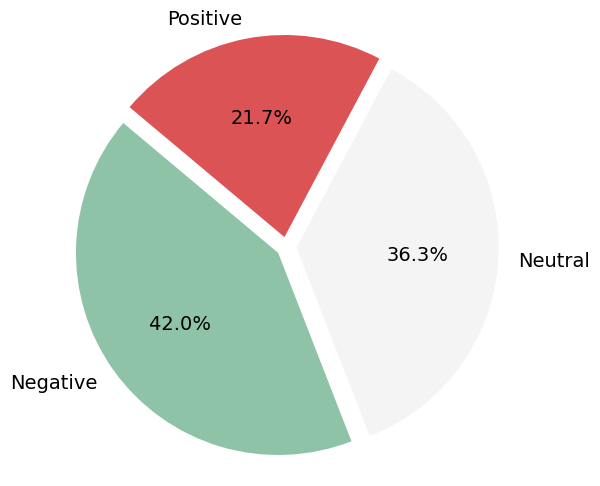

In [11]:
# Create a pie chart
explode = [0.05, 0.05, 0.05]

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index.str.title(), autopct='%1.1f%%',
        startangle=140, colors=['#8EC3A7', '#f4f4f4', '#DC5356'],
        textprops={'fontsize': 14}, explode=explode)
# plt.title('Sentiment Distribution of Tweets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Positive Sentiment**

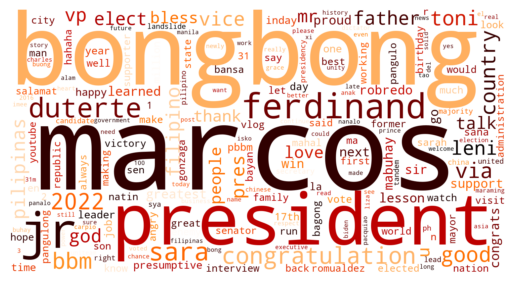

In [12]:
pos_tokens = np.concatenate(df.loc[df.sentiment=='positive'].clean_tweet.str.split().tolist())
plot_wordcloud(pos_tokens, 'Positive Tweets')

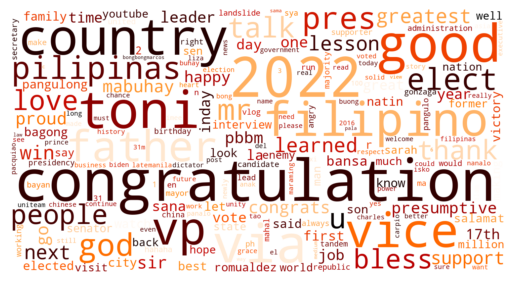

In [13]:
pos_tokens = np.concatenate(df.loc[df.sentiment=='positive'].clean_tweet2.str.split().tolist())
plot_wordcloud(pos_tokens, 'Positive Tweets')

**Neutral Sentiment**

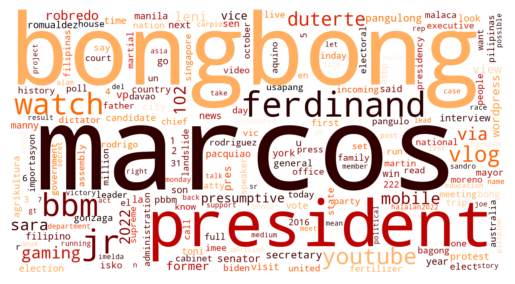

In [14]:
neutral_tokens = np.concatenate(df.loc[df.sentiment=='neutral'].clean_tweet.str.split().tolist())
plot_wordcloud(neutral_tokens, 'Neutral Tweets')

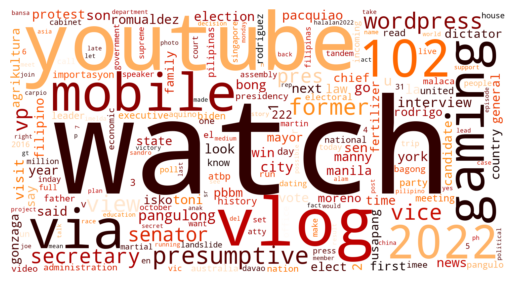

In [15]:
neutral_tokens = np.concatenate(df.loc[df.sentiment=='neutral'].clean_tweet2.str.split().tolist())
plot_wordcloud(neutral_tokens, 'Neutral Tweets')

**Negative Sentiment**

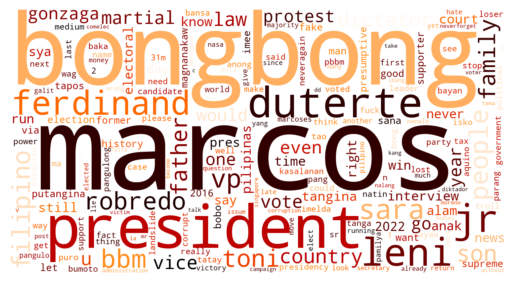

In [16]:
negative_tokens = np.concatenate(df.loc[df.sentiment=='negative'].clean_tweet.str.split().tolist())
plot_wordcloud(negative_tokens, 'Negative Tweets')

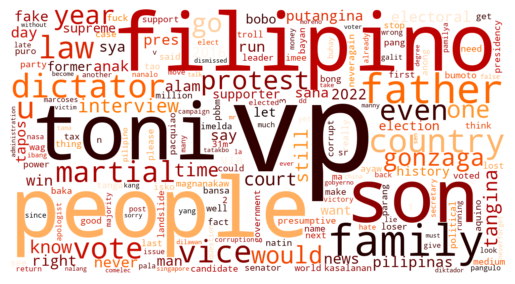

In [17]:
negative_tokens = np.concatenate(df.loc[df.sentiment=='negative'].clean_tweet2.str.split().tolist())
plot_wordcloud(negative_tokens, 'Negative Tweets')

# Political Leaning

In [18]:
leni_keywords = ['leni', 'lenirobredo', 'robredo', 'pink', 'letlenilead',
                 'angatbuhay', 'labanleni2022', 'dapatsileni', 
                 'husayattibay', 'kerinileni'] #pinklawans, dilawans
bbm_keywords = ['bbm', 'bongbong', 'marcos', 'ferdinand',
                'jr', 'bbmxsara', 'marcosxduterte', 'bongbongmarcos', 'inday',
                'duterte', 'sara', 'bong', 'bbmforpresident2022', 'bbm2022']

# Function to check if any keyword is present in the tweet
def term_count(tweet, keywords):
    tweet_lower = tweet.lower()
    return (sum(re.search(r'\b{}\b'.format(re.escape(keyword)), tweet_lower)
                is not None for keyword in keywords))

df['leni'] = df['clean_tweet'].apply(lambda x: term_count(x, leni_keywords))
df['bbm'] = df['clean_tweet'].apply(lambda x: term_count(x, bbm_keywords))

In [19]:
# Political leaning
# Pro-BBM
df.loc[df.loc[((df.bbm > df.leni) & (df.sentiment == 'positive'))
      | ((df.bbm < df.leni) & (df.sentiment == 'negative'))].index, 'polarity'] = -1

# Neutral
# df.loc[df.loc[df.sentiment=='neutral'].index, 'polarity'] = 0
df.loc[df.loc[df.bbm == df.leni].index, 'polarity'] = 0

# Pro Leni
df.loc[df.loc[((df.leni > df.bbm) & (df.sentiment == 'positive'))
      | ((df.leni < df.bbm) & (df.sentiment == 'negative'))].index, 'polarity'] = 1

In [20]:
df.head()

datetime          user  \
0 2021-10-04 23:23:26+00:00   adprlaw1987   
1 2021-10-04 22:18:15+00:00      gero_rgo   
2 2021-10-04 21:36:29+00:00       renpos2   
3 2021-10-04 21:12:36+00:00  ronamgavin12   
4 2021-10-04 20:35:16+00:00       rodev10   

                                               tweet sentiment        date  \
0  So, what will it be? From the looks of it, and...   neutral  2021-10-04   
1  The Greatest Lesson Bongbong Marcos Learned Fr...  positive  2021-10-04   
2  @inquirerdotnet Question: Has the Marcos famil...  negative  2021-10-04   
3  @bongbongmarcos the OG VP Bongbong…\nsana hind...  positive  2021-10-04   
4  @TVPatrol Delicadeza naman for Bongbong Marcos...  negative  2021-10-04   

             user_to                                        clean_tweet  \
0                 []  look unless inside source wrong fight isko mor...   
1         [@YouTube]  greatest lesson bongbong marcos learned father...   
2  [@inquirerdotnet]   question marcos family returned every peso st...   
3  [@bongbongmarcos]   og vp bongbong sana huli tandem bbmxsara bbmx...   
4        [@TVPatrol]   delicadeza bongbong marcos remind pdp organiz...   

                                        clean_tweet2  leni  bbm  polarity  
0  look unless inside source wrong fight isko mor...     0    4       NaN  
1      greatest lesson learned father toni talk via      0    2      -1.0  
2   question family returned every peso stole cof...     0    2       1.0  
3   og vp sana huli tandem bbmxsara bbmxgo 2022 s...     0    2      -1.0  
4   delicadeza remind pdp organized party oust da...     0    2       1.0

In [21]:
df_polarized = df.loc[~df.polarity.isnull()]
df_user_polarity = df_polarized.groupby('user').polarity.mean().reset_index(name='avg_polarity')

In [22]:
df_polarized.shape, df_user_polarity.shape, df_user_polarity.user.nunique()

((9651, 11), (6190, 2), 6190)

In [23]:
print(f'Pro-Leni: {df_user_polarity.loc[df_user_polarity.avg_polarity > 0].user.nunique()}')
print(f'Neutral: {df_user_polarity.loc[df_user_polarity.avg_polarity == 0].user.nunique()}')
print(f'Pro-BBM: {df_user_polarity.loc[df_user_polarity.avg_polarity < 0].user.nunique()}')

Pro-Leni: 3929
Neutral: 312
Pro-BBM: 1949


## Polarity Distribution

In [24]:
df_user_polarity.head()

user  avg_polarity
0          0062ap          -1.0
1      0152josaga           0.0
2   03_Decks_Dark           1.0
3  03_selenophile           1.0
4           03jw_           1.0

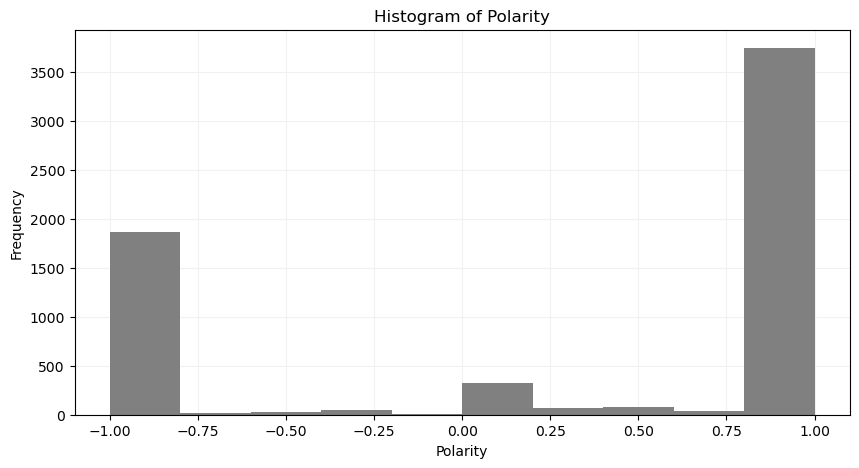

In [25]:
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df_user_polarity['avg_polarity'], bins=10, color='gray', zorder=2)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Histogram of Polarity')
plt.grid(True, color='#f1f1f1')
plt.show()

C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\3316603007.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr_r')
C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\3316603007.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6)


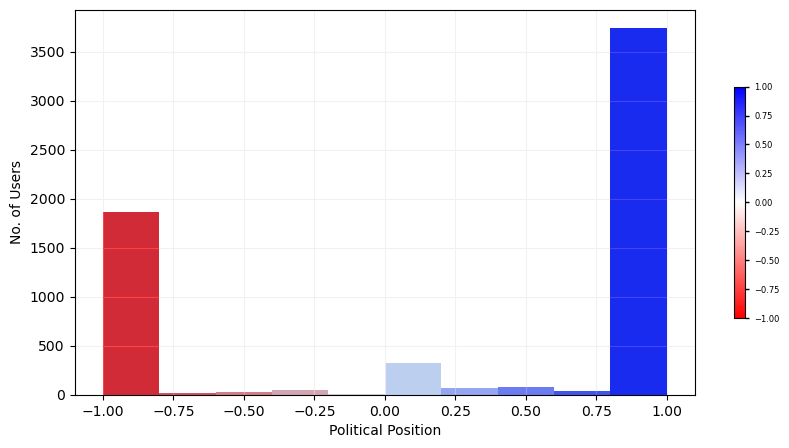

In [26]:
# Define the number of bins for the histogram
num_bins = 10

# Create a colormap from red to blue
cmap = plt.cm.get_cmap('bwr_r')

# Normalize the polarity values to the range [0, 1]
norm = plt.Normalize(vmin=df_user_polarity['avg_polarity'].min(),
                     vmax=df_user_polarity['avg_polarity'].max())

# Plot histogram with colored bins based on polarity values
plt.figure(figsize=(10, 5))

# Get the histogram data and bin edges
n, bins, _ = plt.hist(df_user_polarity['avg_polarity'], bins=num_bins)

# Calculate the bin widths
bin_widths = np.diff(bins)

# Iterate over each bin and plot it with its corresponding color
for i in range(num_bins):
    color = cmap(norm((bins[i] + bins[i + 1]) / 2))
    plt.bar(bins[i], n[i], width=bin_widths[i], align='edge', alpha=0.8,
            color=color, zorder=2)

plt.xlabel('Political Position')
plt.ylabel('No. of Users')
# plt.title('Histogram of Polarity')

# Add a colorbar to show the polarity values associated with colors
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), shrink=0.6)
# cbar.set_label('Avg. Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)
plt.grid(True, color='#f1f1f1')
plt.show()

## Activity vs. Leaning

In [27]:
df_activity = df.groupby('user').datetime.nunique().reset_index(name='num_tweets')

In [28]:
df_user_polarity = df_user_polarity.merge(df_activity, on='user', how='left')

In [29]:
df_user_polarity

user  avg_polarity  num_tweets
0             0062ap          -1.0           1
1         0152josaga           0.0           3
2      03_Decks_Dark           1.0           1
3     03_selenophile           1.0           2
4              03jw_           1.0           1
...              ...           ...         ...
6185        zxxxzauU           1.0           1
6186       zyiteblog          -1.0           9
6187      zynapsesss           1.0           1
6188       zynlauver           1.0           1
6189      zzzhizzzon           1.0           2

[6190 rows x 3 columns]

In [30]:
df_pol_freq = df_user_polarity.groupby('avg_polarity').num_tweets.mean().reset_index(name='avg_activity')

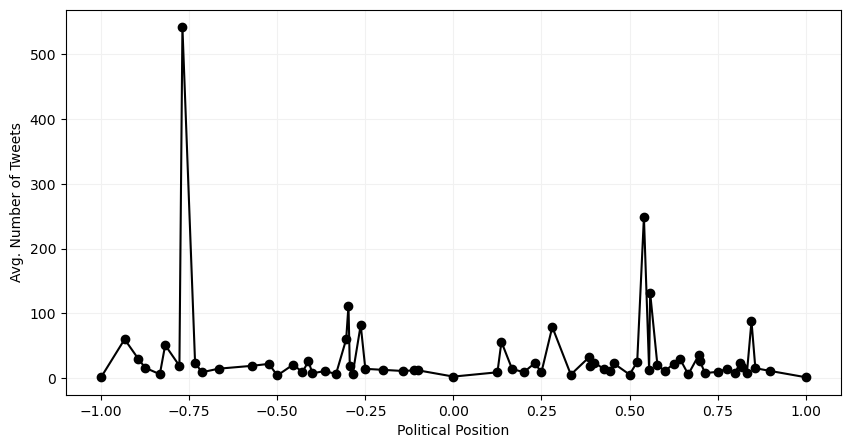

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(df_pol_freq.avg_polarity, df_pol_freq.avg_activity, marker='o', color='k')
plt.ylabel('Avg. Number of Tweets')
plt.xlabel('Political Position')
plt.grid(True, color='#f1f1f1')
plt.show()

# Unraveling the Polarized Political Sphere

In [32]:
# No self-loops
df_conn_from = df_connections.loc[df_connections.user != df_connections.user_to]
df_conn_to = df_conn_from.groupby('user_to').num_mentions.sum().sort_values(ascending=False).reset_index(name='num_mentions')

In [33]:
df_users = pd.DataFrame(np.unique(np.concatenate((df_conn_from.user.unique(),
                        df_conn_from.user_to.unique()))), columns=['user'])
df_users = df_users.merge(df_user_polarity, on='user', how='left') # add avg_polarity
df_users = df_users.merge(df_conn_to, left_on='user', right_on='user_to', how='left').drop(columns='user_to') # add num of mentions
df_users[['num_tweets', 'num_mentions']] = df_users[['num_tweets', 'num_mentions']].fillna(0) # fill missing values with 0

In [34]:
def contains_keywords(username, keyword_list):
    for keyword in keyword_list:
        if keyword in username.lower():
            return True
    return False

# Infer political leaning from usernames of the account
leni_usernames = ['leni', 'lenirobredo', 'robredo', 'pink', 'letlenilead',
                 'angatbuhay', 'labanleni2022', 'dapatsileni', 'kakampink',
                 'husayattibay', 'kerinileni']
bbm_usernames = ['bbm', 'bongbong', 'marcos', 'bongbongmarcos']

df_users['leni'] = df_users.user.apply(lambda x: contains_keywords(x, leni_usernames))
df_users['bbm'] = df_users.user.apply(lambda x: contains_keywords(x, bbm_usernames))


# Manually correct the wrong tags
leni_corrections = [362, 1611, 1612, 1827, 3036, 3043, 3325, 5433]
bbm_corrections = [579, 995, 6033]

df_users.loc[leni_corrections, 'leni'] = False
df_users.loc[bbm_corrections, 'bbm'] = False

df_users.loc[df_users.loc[df_users.leni==True].index, 'avg_polarity'] = 1
df_users.loc[df_users.loc[df_users.bbm==True].index, 'avg_polarity'] = -1

In [35]:
# # Set the news accounts as Neutral
# news_accounts = ['inquirerdotnet', 'ABSCBNNews', 'rapplerdotcom', 'cnnphilippines',
#                 'PhilippineStar', 'manilabulletin', 'gmanews', 'News5PH', 'smninews',
#                 'ANCALERTS', 'onenewsph']
# df_users.loc[df_users[df_users.user.isin(news_accounts)].index, 'avg_polarity'] = 0

In [36]:
# Include users that interacted with others at least once
df_users_with_polarity = (df_users.loc[~df_users.avg_polarity.isnull()]
                                  .drop(columns=['leni', 'bbm']).reset_index(drop=True))

In [37]:
df_users_with_polarity.head()

user  avg_polarity  num_tweets  num_mentions
0      0152josaga      0.000000         3.0           0.0
1  03_selenophile      1.000000         2.0           0.0
2  05WILDFLOWER09      1.000000         4.0           3.0
3          07Red2     -0.333333         5.0           2.0
4          0975jw      1.000000         1.0           0.0

In [38]:
df_conn_with_polarity = df_conn_from.loc[(df_conn_from.user.isin(df_users_with_polarity.user.unique()))
                                    & (df_conn_from.user_to.isin(df_users_with_polarity.user.unique()))]

In [39]:
df_conn_with_polarity.shape, df_conn_with_polarity.user.nunique(), df_conn_with_polarity.user_to.nunique()

((1441, 3), 1043, 341)

In [40]:
df_users_with_polarity.user.nunique()

2686

In [41]:
df.loc[df.user.isin(df_users_with_polarity.user.unique())][['datetime', 'user', 'tweet', 'sentiment', 'user_to', 'clean_tweet', 'leni', 'bbm', 'polarity']].iloc[100:105]

datetime          user  \
226 2021-10-01 15:04:52+00:00     prxm_sntr   
229 2021-10-01 13:33:58+00:00    Obligeant1   
235 2021-10-01 09:53:22+00:00  dexterbrey29   
237 2021-10-01 09:18:11+00:00    gayle_ca01   
238 2021-10-01 09:08:25+00:00   lexsardinis   

                                                 tweet sentiment  \
226  @bongbongmarcos Can't wait super bagay po sain...  positive   
229  @jose_samaritan Angpaw daw ang lahat🤣🤣🤣 at si ...  negative   
235                         @limbertqc Bongbong Marcos  negative   
237  @rapplerdotcom @newsdwight @reyaika @ramborepo...  positive   
238  Seryosong kandidato, di Payaso\n\nNaging tradi...  negative   

                                               user_to  \
226                                  [@bongbongmarcos]   
229                                  [@jose_samaritan]   
235                                       [@limbertqc]   
237  [@rapplerdotcom, @newsdwight, @reyaika, @rambo...   
238                                                 []   

                                           clean_tweet  leni  bbm  polarity  
226   wait super bagay sainyo president ferdinand b...     0    5      -1.0  
229                angpaw bongbong marcos lng malakas      0    2       1.0  
235                                    bongbong marcos     0    2       1.0  
237   lol boxing thing salute politics vote bongbon...     0    2      -1.0  
238  seryosong kandidato payaso tradisyon unang ara...     2    4       1.0

## Visualization

In [42]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with avg_polarity as node attributes
for _, node_data in df_users_with_polarity.iterrows():
    G.add_node(node_data['user'], avg_polarity=node_data['avg_polarity'])

# Add edges between nodes based on 'user_from' and 'user_to'
for _, edge_data in df_conn_with_polarity.iterrows():
    G.add_edge(edge_data['user'], edge_data['user_to'], weight=edge_data['num_mentions'])
    
# Get nodes with non-zero degree (excluding isolated nodes)
non_isolated_nodes = [node for node in G.nodes() if G.degree(node) > 0]

# Create a subgraph with non-isolated nodes
G = G.subgraph(non_isolated_nodes).copy()

C:\Users\ds-pgc\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(
C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\2015214717.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)


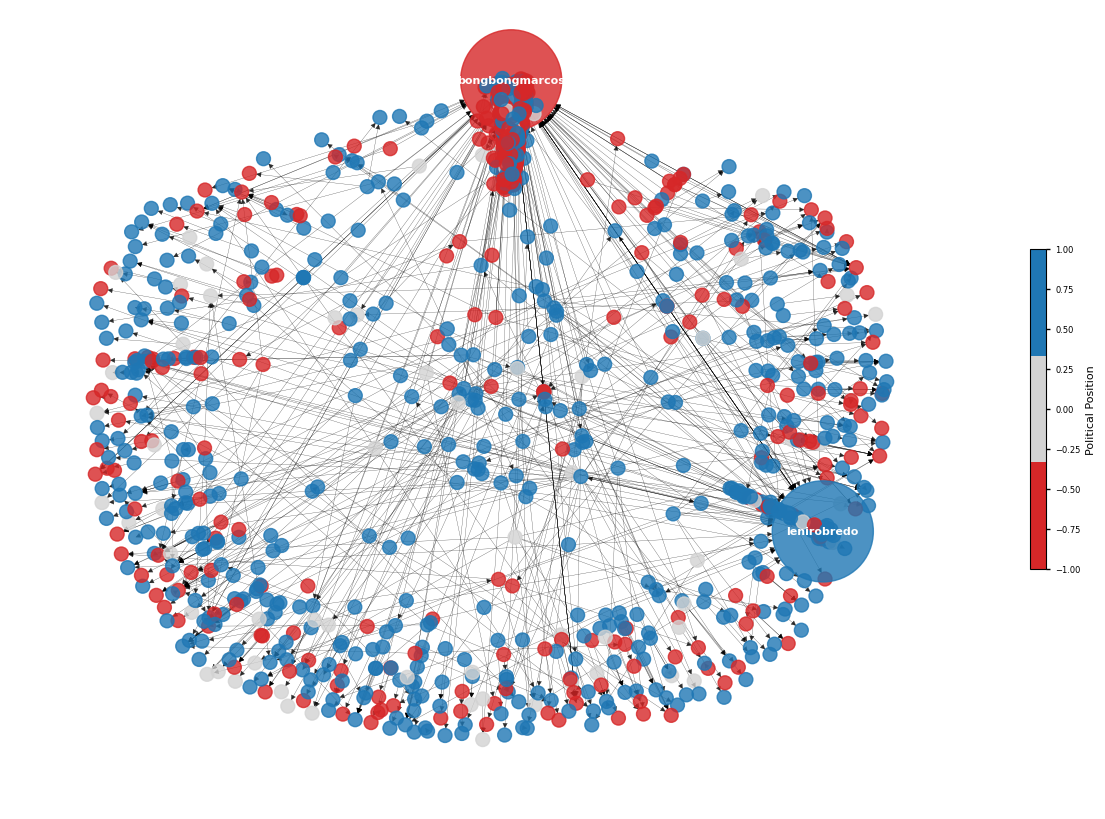

In [43]:
candidates = ['lenirobredo', 'bongbongmarcos']

# Filter nodes based on degree to show a subset of nodes in the plot
min_degree = 1  # Adjust the minimum degree threshold as needed
filtered_nodes = [node for node in G.nodes() if G.degree(node) >= min_degree]

# Create a subgraph with the filtered nodes and their neighbors
subgraph = G.subgraph(filtered_nodes).copy()

# Plot the directed graph
plt.figure(figsize=(12, 8))

# Create a custom colormap with three colors: lightgray, blue, and red
colors = ['tab:red', 'lightgray', 'tab:blue']
cmap = mcolors.ListedColormap(colors)

# Assign colors to nodes based on their 'avg_polarity' attribute
node_colors = []
node_sizes = []
for node in subgraph.nodes():
    avg_polarity = subgraph.nodes[node].get('avg_polarity', 0)
    if avg_polarity < -0.05:
        node_colors.append('tab:red')
    elif avg_polarity > 0.05:
        node_colors.append('tab:blue')
    else:
        node_colors.append('lightgray')
    
    # Set larger node size for candidates
    if node in candidates:
        node_sizes.append(5300)
    else:
        node_sizes.append(100)

pos = nx.spring_layout(subgraph, seed=randstate)  # Change layout algorithm as needed

# Draw nodes without labels
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color=node_colors,
        cmap=cmap, vmin=-1, vmax=1, font_size=10, font_weight='bold', alpha=0.8,
        width=0.2, arrowsize=8)

# Draw nodes with labels for nodes in the candidates list
nx.draw_networkx_labels(subgraph, pos, labels={node: node if node in candidates
                                               else '' for node in subgraph.nodes()},
                        font_size=8, font_color='white', font_weight='bold')

# Add a colorbar to show the polarity values associated with node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)
cbar.set_label('Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)

# plt.title('Directed Graph with Node Attributes and Weighted Edges')
plt.axis('off')
plt.show()

**Pro-Leni**

C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\3415264289.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)


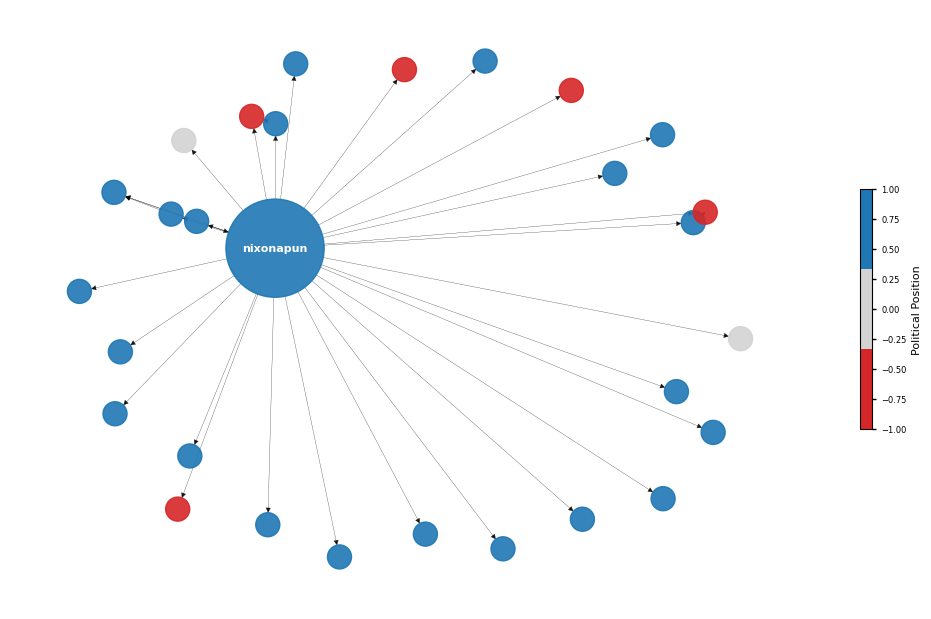

In [44]:
# Get the neighbors of the specific node
focused_node = 'nixonapun'

# Get all the edges connected to the specific node
edges = G.edges(focused_node)

# Create a subgraph containing the specific node and its interactions (edges)
subgraph = G.subgraph([focused_node] + [v for u, v in edges])

# Plot the directed graph
plt.figure(figsize=(10, 6))

# Create a custom colormap with three colors: lightgray, blue, and red
colors = ['tab:red', 'lightgray', 'tab:blue']
cmap = mcolors.ListedColormap(colors)

# Assign colors to nodes based on their 'avg_polarity' attribute
node_colors = []
node_sizes = []
for node in subgraph.nodes():
    avg_polarity = subgraph.nodes[node].get('avg_polarity', 0)
    if avg_polarity < -0.05:
        node_colors.append('tab:red')
    elif avg_polarity > 0.05:
        node_colors.append('tab:blue')
    else:
        node_colors.append('lightgray')
    
    # Set larger node size for candidates
    if node == focused_node:
        node_sizes.append(5000)
    else:
        node_sizes.append(300)

pos = nx.spring_layout(subgraph, seed=randstate)  # Change layout algorithm as needed

# Draw nodes without labels
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color=node_colors,
        cmap=cmap, vmin=-1, vmax=1, font_size=10, font_weight='bold', alpha=0.9,
        width=0.2, arrowsize=8)

# Draw nodes with labels for nodes in the candidates list
nx.draw_networkx_labels(subgraph, pos, labels={node: node if node==focused_node
                                               else '' for node in subgraph.nodes()},
                        font_size=8, font_color='white', font_weight='bold')

# Add a colorbar to show the polarity values associated with node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)
cbar.set_label('Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)

# plt.title('Directed Graph with Node Attributes and Weighted Edges')
plt.axis('off')
plt.show()

**Pro-BBM**

C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\3252572774.py:53: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)


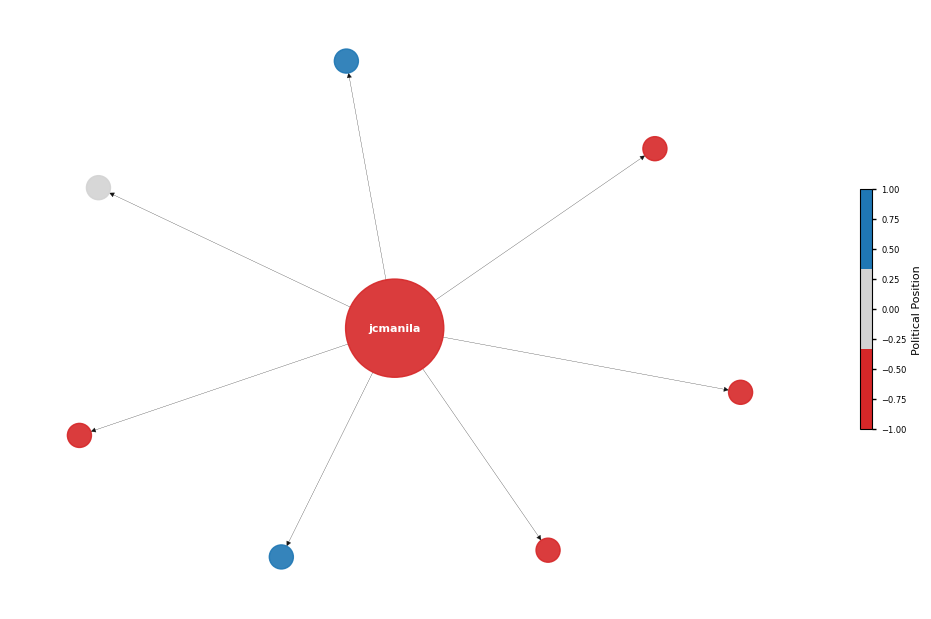

In [45]:
# Get the neighbors of the specific node
focused_node = 'jcmanila'

# Get all the edges connected to the specific node
edges = G.edges(focused_node)

incoming_nodes = [u for u, v in edges]

# Create a subgraph containing the specific node and its interactions (edges)
subgraph_nodes = [focused_node] + [v for u, v in edges] + incoming_nodes
subgraph = G.subgraph(subgraph_nodes)

# Plot the directed graph
plt.figure(figsize=(10, 6))

# Create a custom colormap with three colors: lightgray, blue, and red
colors = ['tab:red', 'lightgray', 'tab:blue']
cmap = mcolors.ListedColormap(colors)

# Assign colors to nodes based on their 'avg_polarity' attribute
node_colors = []
node_sizes = []
for node in subgraph.nodes():
    avg_polarity = subgraph.nodes[node].get('avg_polarity', 0)
    if avg_polarity < -0.05:
        node_colors.append('tab:red')
    elif avg_polarity > 0.05:
        node_colors.append('tab:blue')
    else:
        node_colors.append('lightgray')
    
    # Set larger node size for candidates
    if node == focused_node:
        node_sizes.append(5000)
    else:
        node_sizes.append(300)

pos = nx.spring_layout(subgraph, seed=randstate)  # Change layout algorithm as needed

# Draw nodes without labels
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color=node_colors,
        cmap=cmap, vmin=-1, vmax=1, font_size=10, font_weight='bold', alpha=0.9,
        width=0.2, arrowsize=8)

# Draw nodes with labels for nodes in the candidates list
nx.draw_networkx_labels(subgraph, pos, labels={node: node if node==focused_node
                                               else '' for node in subgraph.nodes()},
                        font_size=8, font_color='white', font_weight='bold')

# Add a colorbar to show the polarity values associated with node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)
cbar.set_label('Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)

# plt.title('Directed Graph with Node Attributes and Weighted Edges')
plt.axis('off')
plt.show()

## Degree Distributions

In [46]:
N = G.order()
L = G.size()

print(f'Nodes: {N}')
print(f'Edges: {L} = {G.number_of_edges()} = {G.number_of_edges()}')

Nodes: 1297
Edges: 1441 = 1441 = 1441


In [47]:
degree_lst = [k for n, k in nx.degree(G)]

print(f'Min. degree: {np.min(degree_lst)}')
print(f'Max. degree: {np.max(degree_lst)}')
print(f'Avg. degree: {np.mean(degree_lst):.3f}')

Min. degree: 1
Max. degree: 583
Avg. degree: 2.222


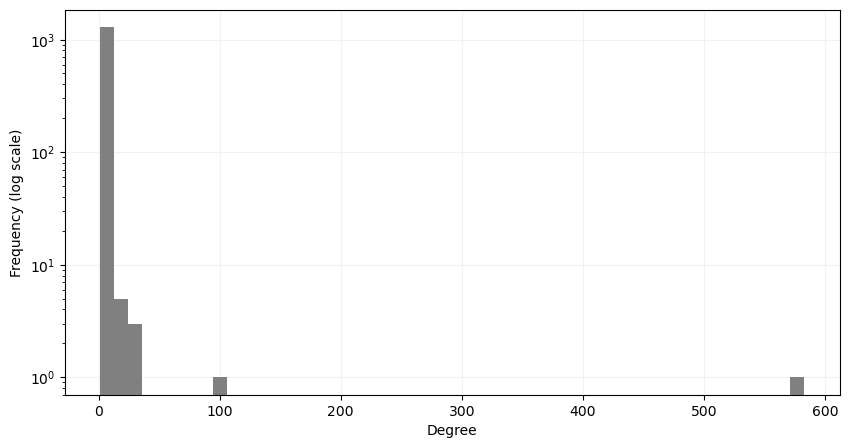

In [48]:
# Plot histogram with a logarithmic scale
plt.figure(figsize=(10, 5))
plt.hist(degree_lst, bins=50, log=True, zorder=2, color='gray')
plt.xlabel('Degree')
plt.ylabel('Frequency (log scale)')
# plt.title('Histogram of Degree Distribution')
plt.grid(True, color='#f1f1f1')
# plt.xscale('log')
plt.show()

In [49]:
in_degrees = list(dict(G.in_degree()).values())

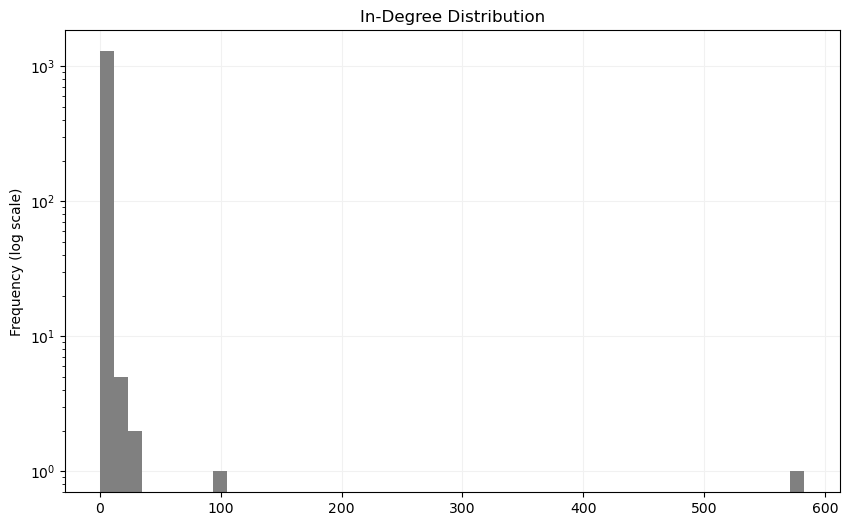

In [50]:
# Plot histogram with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=50, log=True, zorder=2, color='gray')
# plt.xlabel('In-Degree')
plt.ylabel('Frequency (log scale)')
plt.title('In-Degree Distribution')
plt.grid(True, color='#f1f1f1')
plt.show()

<span style="color:#00A5D3; font-size:14px; font-weight:bold"><i>What's the out-degree distribution in the network?</i></span> 

In [51]:
out_degrees = list(dict(G.out_degree()).values())

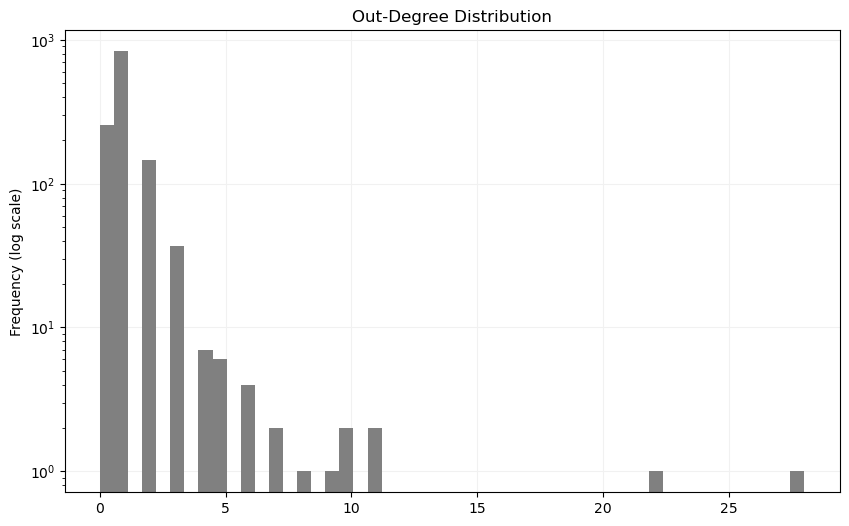

In [52]:
# Plot histogram with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.hist(out_degrees, bins=50, log=True, zorder=2, color='gray')
# plt.xlabel('Out-Degree')
plt.ylabel('Frequency (log scale)')
plt.title('Out-Degree Distribution')
plt.grid(True, color='#f1f1f1')
plt.show()

In [53]:
cc = nx.clustering(G)
avg_clust = sum(cc.values()) / len(cc)
print(f'{avg_clust:3f}')

0.022580


# Understanding the Effect of Homophily on Information Flow

## Assortativity

In [54]:
# in-in
print(nx.degree_assortativity_coefficient(G, x='in', y='in'))

# in-out
print(nx.degree_assortativity_coefficient(G, x='in', y='out'))

# out-in
print(nx.degree_assortativity_coefficient(G, x='out', y='in'))

# out-out
print(nx.degree_assortativity_coefficient(G, x='out', y='out'))

-0.035034653959352485
0.03230580662462186
-0.24933507937942123
0.03589181604799496


In [55]:
print(nx.attribute_assortativity_coefficient(G, 'avg_polarity'))

0.20931145411133792


## Strongly Connected Component

In [56]:
# Find strongly connected components
strongly_connected_components = sorted(list(nx.strongly_connected_components(G)), key=len, reverse=True)

# Find the largest strongly connected component (SCC)
largest_scc = max(strongly_connected_components, key=len)

In [57]:
largest_scc

{'BusinessMirror', 'jrsanjuan1573', 'sam_medenilla'}

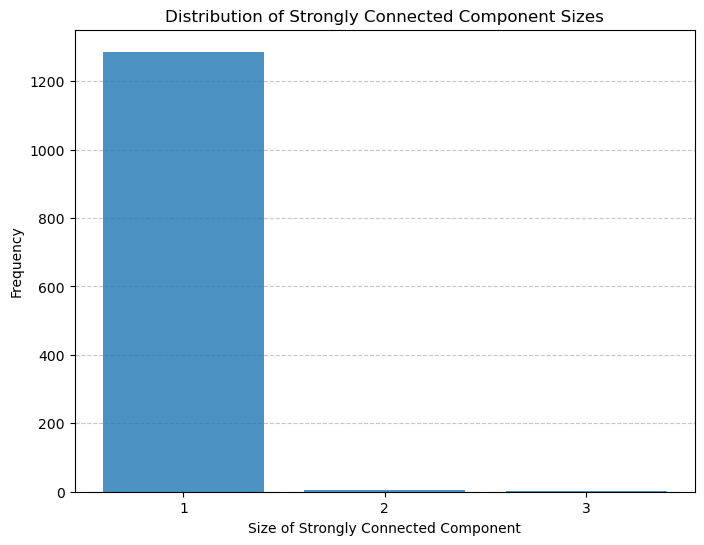

In [58]:
# Get the list of strongly connected components
scc_list = list(nx.strongly_connected_components(G))

# Calculate the size (number of nodes) of each strongly connected component
scc_sizes = [len(scc) for scc in scc_list]

# Plot the distribution of SCC sizes using a histogram
plt.figure(figsize=(8, 6))
plt.hist(scc_sizes, bins=range(1, max(scc_sizes) + 2), align='left',
         alpha=0.8, rwidth=0.8, zorder=2)
plt.xlabel('Size of Strongly Connected Component')
plt.ylabel('Frequency')
plt.title('Distribution of Strongly Connected Component Sizes')
plt.xticks(range(1, max(scc_sizes) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Identifying Kingmakers and Opinion Leaders

In [59]:
# Define functions for network properties
def get_central_nodes(centrality_dict, threshold):
    """
    Return a list of central nodes based on the given centrality
    measure and threshold.

    Parameters
    ----------
    centrality_dict : dict
        A dictionary containing centrality measures of nodes in the graph.

    threshold : float
        The threshold value for centrality. Nodes with centrality values
        greater than the threshold will be considered central.
    """
    return [node for node, centrality in centrality_dict.items()
                if centrality > threshold]

def plot_centrality_dist(G, centrality_dict, fig_title, figsize=(8, 6),
                         threshold=None, logged=False):
    """
    Plot the distribution of centrality measures in the graph.

    Parameters
    -------------
    
    G : networkx.Graph
        The input graph.
        
    centrality_dict : dict
        A dictionary containing centrality measures of nodes in the graph.
        
    fig_title : str
        The title for the plot.
        
    threshold : float or None (optional)
        The threshold value for visualization. If specified,
        a vertical line is added to the plot. Defaults to None.
        
    figsize : tuple (optional)
        The size of the figure (width, height) in inches. Defaults to (8, 6).
    """
    # Get the degrees of all nodes in the graph
    centrality_dist = [centrality_dict[node] for node in G.nodes()]

    plt.figure(figsize=figsize)
    # Plot the degree distribution
    plt.hist(centrality_dist, bins=20, alpha=0.7, color='#00A5D3', log=logged)
             #edgecolor='black'

    if threshold is not None:
        # Add a vertical line at the threshold
        plt.axvline(x=threshold, color='r', linestyle='--',
                    label=f'Threshold ({threshold:.2f})', alpha=0.5)
    
    ax = plt.gca()

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlabel('Centrality')
    plt.ylabel('Number of Nodes')
    
    plt.title(fig_title)
    plt.show()

## Total degree

**Eigencentrality**

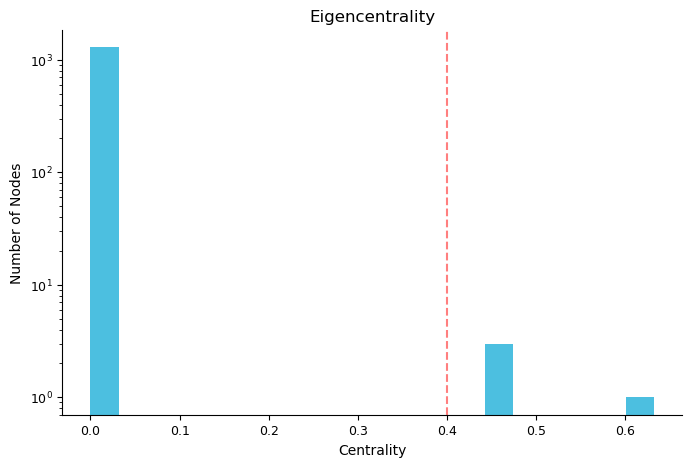

In [60]:
eig_centrality = nx.eigenvector_centrality(G)

thresh = 0.4
title = f'Eigencentrality'
plot_centrality_dist(G, eig_centrality, title, figsize=(8,5),
                     threshold=thresh, logged=True)

In [61]:
# Get the central nodes
central_nodes_e = get_central_nodes(eig_centrality, thresh)
for node in central_nodes_e:
    print(f'Node: {node} -- Eigencentrality: {eig_centrality[node]:.3f}')

Node: jrsanjuan1573 -- Eigencentrality: 0.447
Node: bongbongmarcos -- Eigencentrality: 0.448
Node: BusinessMirror -- Eigencentrality: 0.632
Node: sam_medenilla -- Eigencentrality: 0.447


C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\1632977910.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)


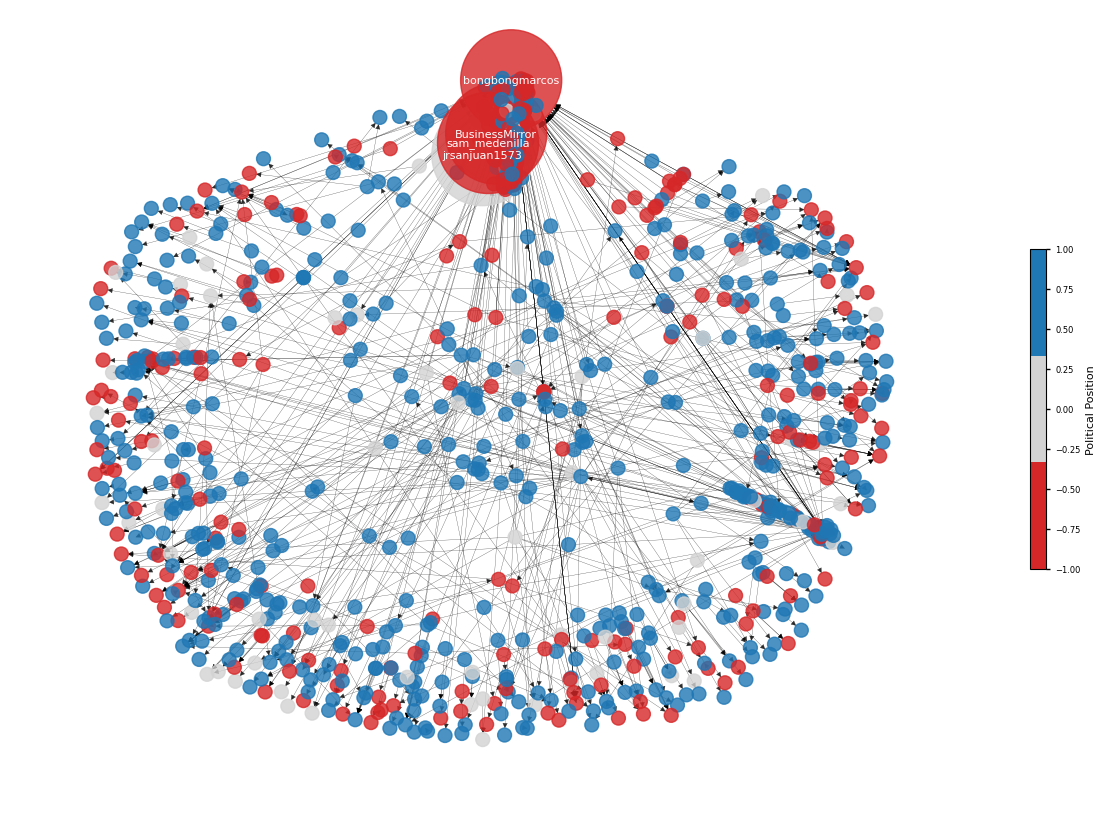

In [62]:
candidates = ['lenirobredo', 'bongbongmarcos']

# Filter nodes based on degree to show a subset of nodes in the plot
min_degree = 1  # Adjust the minimum degree threshold as needed
filtered_nodes = [node for node in G.nodes() if G.degree(node) >= min_degree]

# Create a subgraph with the filtered nodes and their neighbors
subgraph = G.subgraph(filtered_nodes).copy()

# Plot the directed graph
plt.figure(figsize=(12, 8))

# Create a custom colormap with three colors: lightgray, blue, and red
colors = ['tab:red', 'lightgray', 'tab:blue']
cmap = mcolors.ListedColormap(colors)

# Assign colors to nodes based on their 'avg_polarity' attribute
node_colors = []
node_sizes = []
for node in subgraph.nodes():
    avg_polarity = subgraph.nodes[node].get('avg_polarity', 0)
    if avg_polarity < -0.05:
        node_colors.append('tab:red')
    elif avg_polarity > 0.05:
        node_colors.append('tab:blue')
    else:
        node_colors.append('lightgray')
    
    # Set larger node size for candidates
    if (node in central_nodes_e):
        node_sizes.append(5300)
    else:
        node_sizes.append(100)

pos = nx.spring_layout(subgraph, seed=randstate)  # Change layout algorithm as needed

# Draw nodes without labels
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color=node_colors,
        cmap=cmap, vmin=-1, vmax=1, font_size=10, alpha=0.8, #, font_weight='bold'
        width=0.2, arrowsize=8)

# Draw nodes with labels for nodes in the candidates list
nx.draw_networkx_labels(subgraph, pos, labels={node: node if node in central_nodes_e
                                               else '' for node in subgraph.nodes()},
                        font_size=8, font_color='white') #, font_weight='bold'

# Add a colorbar to show the polarity values associated with node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)
cbar.set_label('Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)

# plt.title('Directed Graph with Node Attributes and Weighted Edges')
plt.axis('off')
plt.show()

**Closeness Centrality**

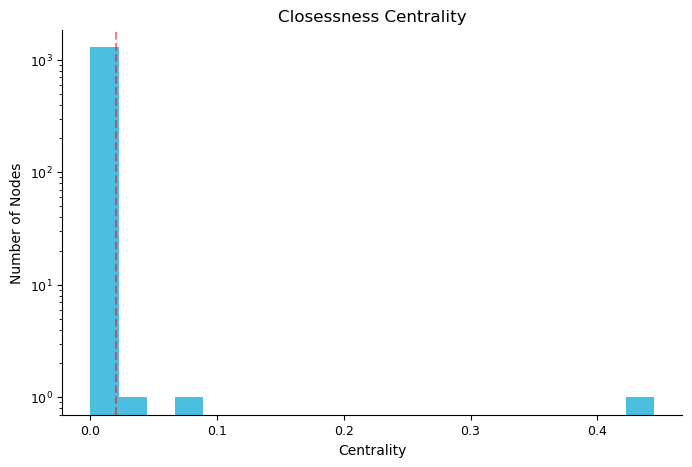

In [63]:
close_centrality = nx.closeness_centrality(G)

thresh = 0.02
title = f'Closessness Centrality'
plot_centrality_dist(G, close_centrality, title, figsize=(8,5),
                     threshold=thresh, logged=True)

In [64]:
# Get the central nodes
central_nodes_c = get_central_nodes(close_centrality, thresh)
for node in central_nodes_c:
    print(f'Node: {node} -- Eigencentrality: {close_centrality[node]:.3f}')

Node: bongbongmarcos -- Eigencentrality: 0.445
Node: paulsoriano1017 -- Eigencentrality: 0.024
Node: datumx11 -- Eigencentrality: 0.021
Node: lenirobredo -- Eigencentrality: 0.082


C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\345758333.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)


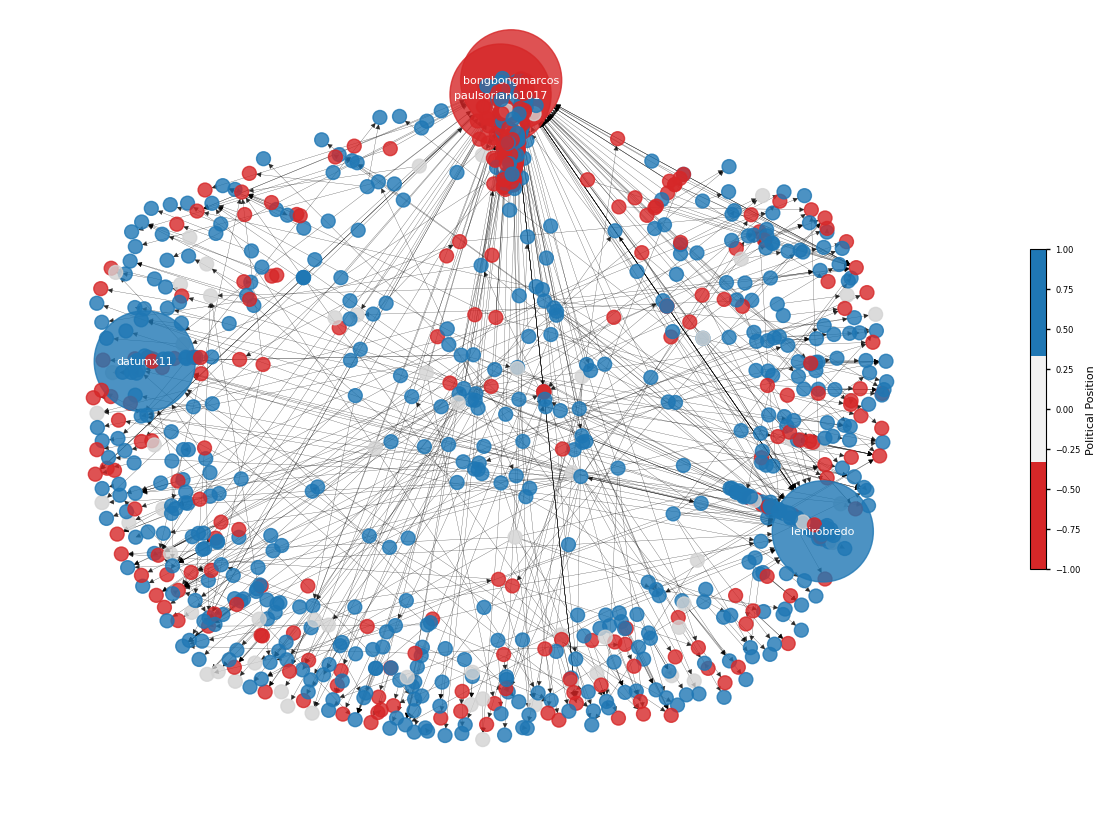

In [65]:
candidates = ['lenirobredo', 'bongbongmarcos']

# Filter nodes based on degree to show a subset of nodes in the plot
min_degree = 1  # Adjust the minimum degree threshold as needed
filtered_nodes = [node for node in G.nodes() if G.degree(node) >= min_degree]

# Create a subgraph with the filtered nodes and their neighbors
subgraph = G.subgraph(filtered_nodes).copy()

# Plot the directed graph
plt.figure(figsize=(12, 8))

# Create a custom colormap with three colors: lightgray, blue, and red
colors = ['tab:red', '#f2f2f2', 'tab:blue']
cmap = mcolors.ListedColormap(colors)

# Assign colors to nodes based on their 'avg_polarity' attribute
node_colors = []
node_sizes = []
for node in subgraph.nodes():
    avg_polarity = subgraph.nodes[node].get('avg_polarity', 0)
    if avg_polarity < -0.05:
        node_colors.append('tab:red')
    elif avg_polarity > 0.05:
        node_colors.append('tab:blue')
    else:
        node_colors.append('lightgray')
    
    # Set larger node size for candidates
    if (node in central_nodes_c):
        node_sizes.append(5300)
    else:
        node_sizes.append(100)

pos = nx.spring_layout(subgraph, seed=randstate)  # Change layout algorithm as needed

# Draw nodes without labels
nx.draw(subgraph, pos, with_labels=False, node_size=node_sizes, node_color=node_colors,
        cmap=cmap, vmin=-1, vmax=1, font_size=10, alpha=0.8,
        width=0.2, arrowsize=8)

# Draw nodes with labels for nodes in the candidates list
nx.draw_networkx_labels(subgraph, pos, labels={node: node if node in central_nodes_c
                                               else '' for node in subgraph.nodes()},
                        font_size=8, font_color='white') #, font_weight='bold'

# Add a colorbar to show the polarity values associated with node colors
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.4)
cbar.set_label('Political Position', fontsize=8)
cbar.ax.tick_params(labelsize=6, size=3, width=1)

# plt.title('Directed Graph with Node Attributes and Weighted Edges')
plt.axis('off')
plt.show()

## Incoming vs. Outgoing degree

In [66]:
# Calculate the in-degree for each node
in_degrees = dict(G.in_degree())

# Sort the nodes based on their in-degree in descending order
sorted_nodes = sorted(in_degrees, key=lambda x: in_degrees[x], reverse=True)

# Set the number of hubs you want to identify (e.g., top 10)
num_hubs = 20

# Get the top N nodes with the highest in-degree (hubs)
in_hubs = sorted_nodes[:num_hubs]
in_hubs

['bongbongmarcos',
 'lenirobredo',
 'paulsoriano1017',
 'datumx11',
 'indaysara',
 'raissawriter',
 'sandromarcos7',
 'LakasNgTimog',
 'Paps_Caloy',
 'GerryCacanindin',
 'lianbuan',
 'MashaMasha2022',
 'anjocalimario',
 'pinoyanghang',
 'Bongbong',
 'AlfredoGenom',
 'theadtan',
 'ilda_talk',
 'marortoll',
 'oslecjunior']

In [67]:
# Calculate the in-degree for each node
out_degrees = dict(G.out_degree())

# Sort the nodes based on their in-degree in descending order
sorted_nodes = sorted(out_degrees, key=lambda x: out_degrees[x], reverse=True)

# Set the number of hubs you want to identify (e.g., top 10)
num_hubs = 20

# Get the top N nodes with the highest in-degree (hubs)
out_hubs = sorted_nodes[:num_hubs]
out_hubs

['nixonapun',
 'JustMe80041125',
 'Gabby51322',
 'Pepe21855368',
 '_wastedwanderer',
 'Abogado_PH',
 'olcapslerkey',
 'prukotooch',
 'Orangee08917011',
 'jcmanila',
 'ChloeLoveLC',
 'n4n4daim3',
 'carfanatic7788',
 'ProfNougat',
 'reclaimer77',
 'Steve24940349',
 'zaldytor',
 'DolorNolet',
 'MekiiMania',
 'wenggonzales']

# Exploring Presence of Echo Chamber

## Avg. Polarity of incoming vs. nearest neighbors'

In [68]:
# Function to compute the average position of incoming connections (PINi) for each node
def compute_average_incoming_position(graph):
    average_incoming_position = {}
    for node in graph.nodes():
        in_edges = graph.in_edges(node, data=True)
        total_weighted_position = 0
        total_weight = 0
        for u, v, data in in_edges:
            weight = data['weight']
            total_weighted_position += weight * graph.nodes[v]['avg_polarity']
            total_weight += weight
        if total_weight > 0:
            average_incoming_position[node] = total_weighted_position / total_weight
        else:
            average_incoming_position[node] = None
    return average_incoming_position


# Function to compute the average position of nearest neighbors (PNNi) for each node
def compute_average_nearest_neighbor_position(graph):
    average_nearest_neighbor_position = {}
    for node in graph.nodes():
        out_edges = graph.out_edges(node, data=True)
        total_weighted_position = 0
        total_weight = 0
        for u, v, data in out_edges:
            weight = data['weight']
            total_weighted_position += weight * graph.nodes[v]['avg_polarity']
            total_weight += weight
        if total_weight > 0:
            average_nearest_neighbor_position[node] = total_weighted_position / total_weight
        else:
            average_nearest_neighbor_position[node] = None
    return average_nearest_neighbor_position

average_incoming_position = compute_average_incoming_position(G)
average_nearest_neighbor_position = compute_average_nearest_neighbor_position(G)

In [69]:
df_in_polarity = pd.DataFrame(list(average_incoming_position.items()), columns=['user', 'avg_in_polarity'])
df_nn_polarity = pd.DataFrame(list(average_nearest_neighbor_position.items()), columns=['user', 'avg_nn_polarity'])

df_in_polarity = df_in_polarity.merge(df_users_with_polarity[['user', 'avg_polarity']], on='user', how='left')
df_nn_polarity = df_nn_polarity.merge(df_users_with_polarity[['user', 'avg_polarity']], on='user', how='left')

In [70]:
df_users.user.nunique(), df_in_polarity.user.nunique()

(6338, 1297)

(341, 3) 341


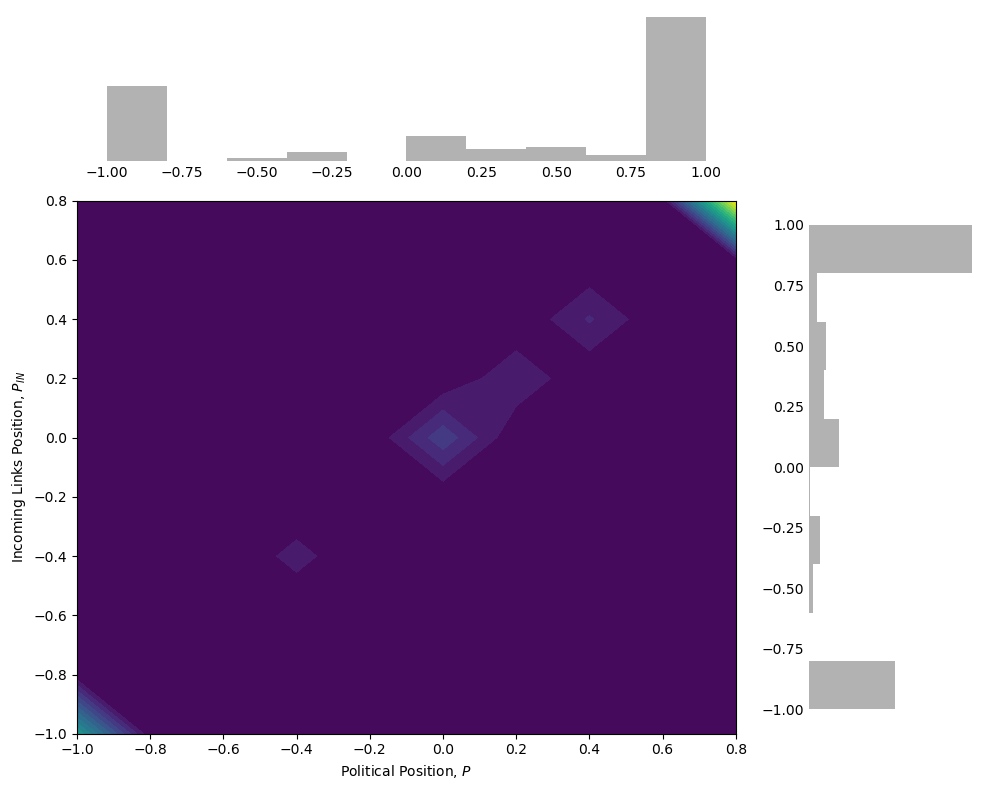

In [71]:
df_plt = df_in_polarity.dropna(subset=['avg_in_polarity'])
print(df_plt.shape, df_plt.user.nunique())

# Create a grid layout for the plots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Create a 2D histogram of 'P_in' vs. 'P'
ax_contour = fig.add_subplot(gs[1:4, 0:3])
hist, xedges, yedges = np.histogram2d(df_plt['avg_polarity'], df_plt['avg_in_polarity'], bins=10)
contour = ax_contour.contourf(xedges[:-1], yedges[:-1], hist.T, cmap='viridis', levels=20)
ax_contour.set_ylabel('Incoming Links Position, $P_{IN}$')
ax_contour.set_xlabel('Political Position, $P$')
# ax_contour.set_title('Contour Map of P_in vs. P')

# Create histograms for 'P_in' and 'P' on the side axes
ax_hist_incoming = fig.add_subplot(gs[1:4, 3])
ax_hist_polarity = fig.add_subplot(gs[0, 0:3])

# Remove frame and tick labels for histograms
ax_hist_incoming.hist(df_plt['avg_in_polarity'], bins=10, color='gray',
                      alpha=0.6, orientation='horizontal')
ax_hist_incoming.spines['top'].set_visible(False)
ax_hist_incoming.spines['right'].set_visible(False)
ax_hist_incoming.spines['bottom'].set_visible(False)
ax_hist_incoming.spines['left'].set_visible(False)
ax_hist_incoming.tick_params(axis='both', which='both', length=0)
ax_hist_incoming.set_xticklabels([]) # polarity
# ax_hist_incoming.set_yticklabels([])

ax_hist_polarity.hist(df_plt['avg_polarity'], bins=10, color='gray', alpha=0.6)
ax_hist_polarity.spines['top'].set_visible(False)
ax_hist_polarity.spines['right'].set_visible(False)
ax_hist_polarity.spines['bottom'].set_visible(False)
ax_hist_polarity.spines['left'].set_visible(False)
ax_hist_polarity.tick_params(axis='both', which='both', length=0)
# ax_hist_polarity.set_xticklabels([])
ax_hist_polarity.set_yticklabels([]) # polarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

(1043, 3) 1043


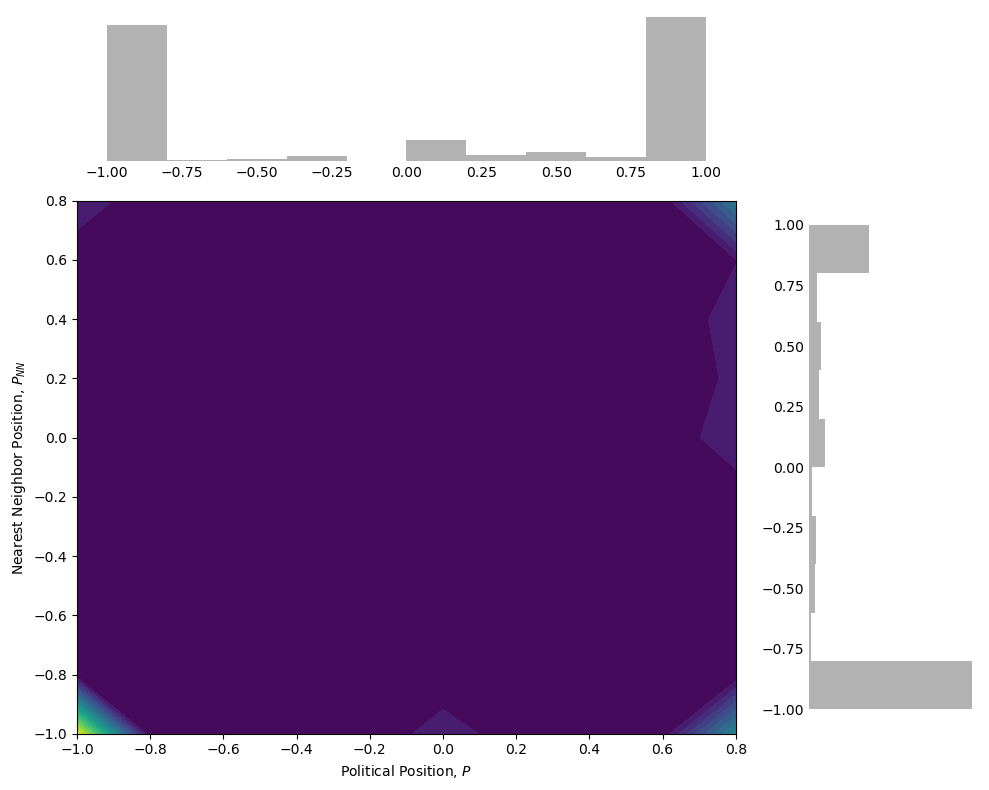

In [72]:
df_plt = df_nn_polarity.dropna(subset=['avg_nn_polarity'])
print(df_plt.shape, df_plt.user.nunique())

# Create a grid layout for the plots
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Create a 2D histogram of 'P_in' vs. 'P'
ax_contour = fig.add_subplot(gs[1:4, 0:3])
hist, xedges, yedges = np.histogram2d(df_plt['avg_polarity'], df_plt['avg_nn_polarity'], bins=10)
contour = ax_contour.contourf(xedges[:-1], yedges[:-1], hist.T, cmap='viridis', levels=20)
ax_contour.set_ylabel('Nearest Neighbor Position, $P_{NN}$')
ax_contour.set_xlabel('Political Position, $P$')
# ax_contour.set_title('Contour Map of P_in vs. P')

# Create histograms for 'P_in' and 'P' on the side axes
ax_hist_incoming = fig.add_subplot(gs[1:4, 3])
ax_hist_polarity = fig.add_subplot(gs[0, 0:3])

# Remove frame and tick labels for histograms
ax_hist_incoming.hist(df_plt['avg_nn_polarity'], bins=10, color='gray',
                      alpha=0.6, orientation='horizontal')
ax_hist_incoming.spines['top'].set_visible(False)
ax_hist_incoming.spines['right'].set_visible(False)
ax_hist_incoming.spines['bottom'].set_visible(False)
ax_hist_incoming.spines['left'].set_visible(False)
ax_hist_incoming.tick_params(axis='both', which='both', length=0)
ax_hist_incoming.set_xticklabels([]) # polarity
# ax_hist_incoming.set_yticklabels([])

ax_hist_polarity.hist(df_plt['avg_polarity'], bins=10, color='gray', alpha=0.6)
ax_hist_polarity.spines['top'].set_visible(False)
ax_hist_polarity.spines['right'].set_visible(False)
ax_hist_polarity.spines['bottom'].set_visible(False)
ax_hist_polarity.spines['left'].set_visible(False)
ax_hist_polarity.tick_params(axis='both', which='both', length=0)
# ax_hist_polarity.set_xticklabels([])
ax_hist_polarity.set_yticklabels([]) # polarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Community detection

In [73]:
G_undirected = G.to_undirected()
G_undirected = nx.Graph(G_undirected)

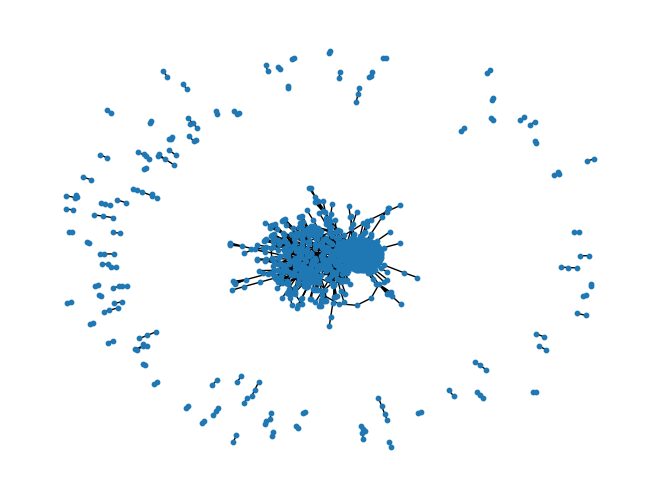

In [74]:
pos = nx.spring_layout(G_undirected)
nx.draw(G_undirected, pos, node_size=10)
plt.show()

In [75]:
GC_nodes = max(nx.connected_components(G_undirected), key=len)
GC = G_undirected.subgraph(GC_nodes).copy()

partition = community.best_partition(GC)
print ("Number of Communities: ", len(set(partition.values())))

Number of Communities:  33


C:\Users\ds-pgc\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


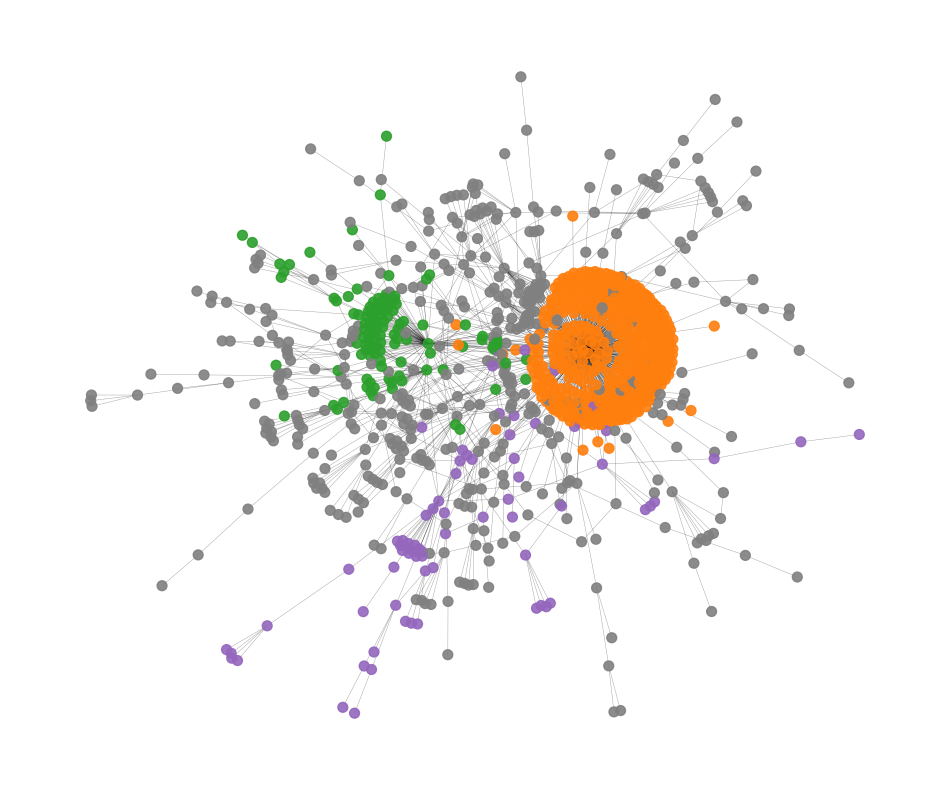

In [76]:
# Get the sizes of the communities
community_sizes = {}
for community_id in partition.values():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Get the three largest communities
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:3]

# Create a color map for the three largest communities
tab10_colors = cm.tab10.colors[1:3] + cm.tab10.colors[4:]
color_map = {community_id: tab10_colors[i] for i, community_id in enumerate(largest_communities)}

# Assign colors to the rest of the communities as gray
gray_color = 'gray'
for community_id in partition.values():
    if community_id not in color_map:
        color_map[community_id] = gray_color

# Assign the colors to nodes based on their community
node_colors = [color_map[partition[node]] for node in GC.nodes()]

plt.figure(figsize=(12, 10))
plt.axis('off')
pos = nx.spring_layout(GC, seed=randstate)
nx.draw_networkx_nodes(GC, pos, node_color=node_colors, node_size=50, alpha=0.9)
nx.draw_networkx_edges(GC, pos, alpha=0.4, width=0.3)
plt.show()

**Top 3 Communities**

In [77]:
# Create dictionaries to store polarity distribution for each top community
top_community_polarity_dist = {community_id: [] for community_id in largest_communities}

# Iterate through the nodes and their polarities
for node, community_id in partition.items():
    if community_id in largest_communities:
        polarity = GC.nodes[node]["avg_polarity"]
        top_community_polarity_dist[community_id].append(polarity)

C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\2560382998.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bwr_r')
C:\Users\ds-pgc\AppData\Local\Temp\ipykernel_4732\2560382998.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


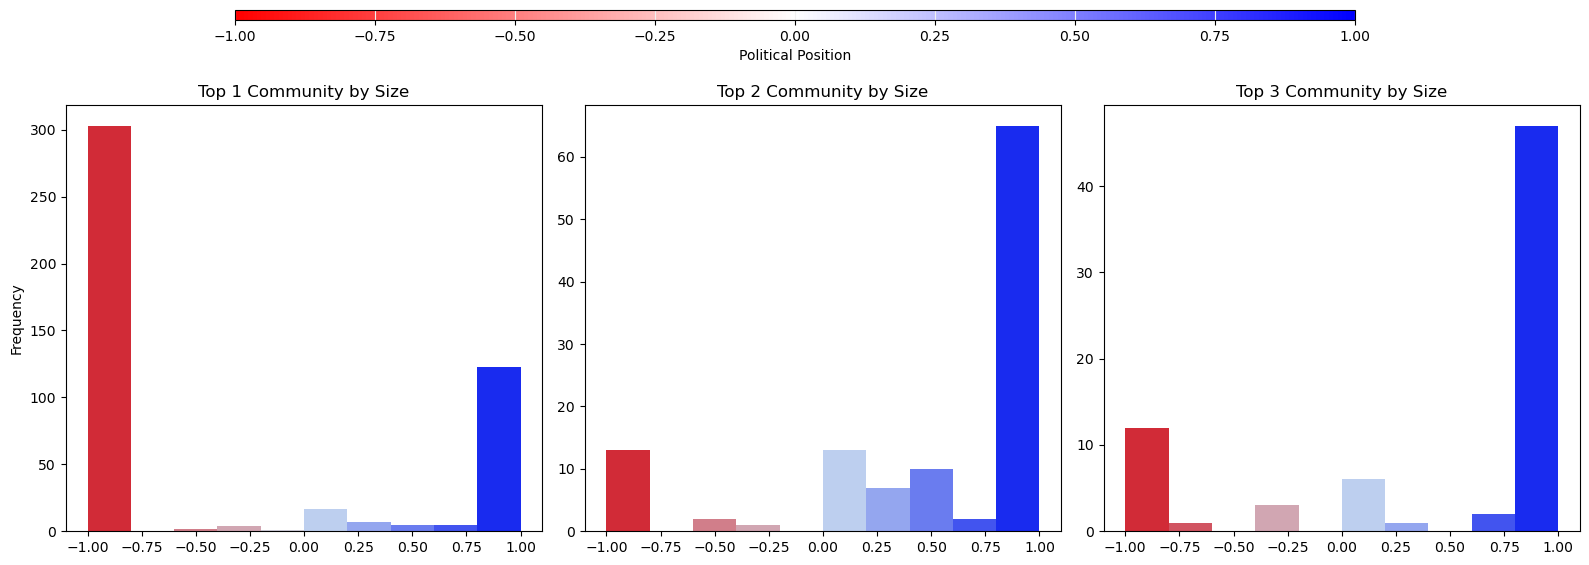

In [78]:
num_bins = 10

# Create a colormap from red to blue
cmap = plt.cm.get_cmap('bwr_r')

# Normalize the polarity values to the range [0, 1]
norm = plt.Normalize(vmin=df_user_polarity['avg_polarity'].min(),
                     vmax=df_user_polarity['avg_polarity'].max())

# Plot histogram with colored bins based on polarity values
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True)

# Get the histogram data and bin edges for each top community
for i, (community_id, polarity_values) in enumerate(top_community_polarity_dist.items(), 1):
    ax = axs[i - 1]

    # Get the histogram data and bin edges
    n, bins, _ = ax.hist(polarity_values, bins=num_bins)

    # Calculate the bin widths
    bin_widths = np.diff(bins)

    # Iterate over each bin and plot it with its corresponding color
    for j in range(num_bins):
        color = cmap(norm((bins[j] + bins[j + 1]) / 2))
        ax.bar(bins[j], n[j], width=bin_widths[j], align='edge', alpha=0.8,
               color=color, zorder=2)

    # Only label y-axis for the leftmost plot
    if i == 1:
        ax.set_ylabel('Frequency')

    # ax.set_xlabel('Polarity')
    ax.set_title(f'Top {i} Community by Size')
    ax.grid(False)

# Add a colorbar to the top subplot to show the polarity values associated with colors
cbar_ax = fig.add_axes([0.15, 1.1, 0.7, 0.02])
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='horizontal')
cbar.set_label('Political Position')
plt.grid(True, color='#f1f1f1')

plt.tight_layout()
plt.show()

In [79]:
# Create dictionaries to store polarity distribution for each top community
top_community_nodes = {community_id: [] for community_id in largest_communities}

# Iterate through the nodes and their polarities
for node, community_id in partition.items():
    if community_id in largest_communities:
        top_community_nodes[community_id].append(node)

In [84]:
top_community_nodes.keys()

dict_keys([0, 28, 17])

**Community 1**

In [80]:
df_com1 = df.loc[df.user.isin(top_community_nodes[0])]
df_com1_info = df_users.loc[df_users.user.isin(top_community_nodes[0])]

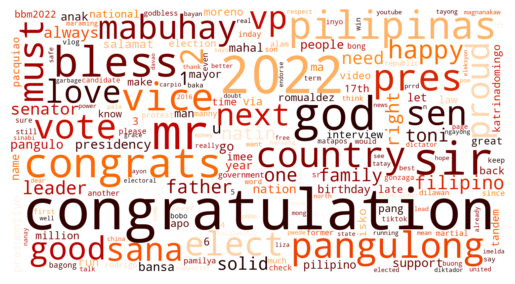

In [81]:
com1_tokens = np.concatenate(df_com1.clean_tweet2.str.split().tolist()) #(df.sentiment=='positive') & 
plot_wordcloud(com1_tokens, 'Positive Tweets')

In [82]:
df_com1_info.loc[df_com1_info.avg_polarity > 0].user.nunique(), df_com1_info.loc[df_com1_info.avg_polarity == 0].user.nunique(), df_com1_info.loc[df_com1_info.avg_polarity < 0].user.nunique()

(140, 17, 310)

**Community 2**

In [85]:
df_com2 = df.loc[df.user.isin(top_community_nodes[28])]
df_com2_info = df_users.loc[df_users.user.isin(top_community_nodes[28])]

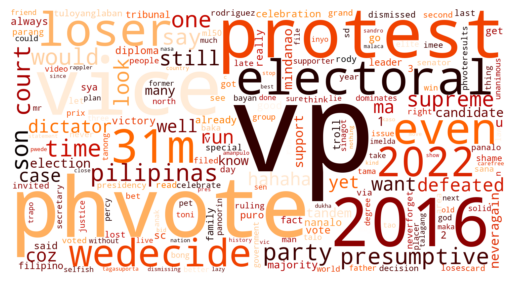

In [86]:
com2_tokens = np.concatenate(df_com2.clean_tweet2.str.split().tolist()) #(df.sentiment=='positive') & 
plot_wordcloud(com2_tokens, 'Positive Tweets')

In [87]:
df_com2_info.loc[df_com2_info.avg_polarity > 0].user.nunique(), df_com2_info.loc[df_com2_info.avg_polarity == 0].user.nunique(), df_com2_info.loc[df_com2_info.avg_polarity < 0].user.nunique()

(84, 13, 16)

**Community 3**

In [88]:
df_com3 = df.loc[df.user.isin(top_community_nodes[17])]
df_com3_info = df_users.loc[df_users.user.isin(top_community_nodes[17])]

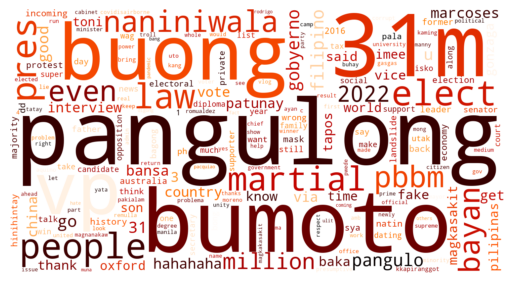

In [89]:
com3_tokens = np.concatenate(df_com3.clean_tweet2.str.split().tolist()) #(df.sentiment=='positive') & 
plot_wordcloud(com3_tokens, 'Positive Tweets')

In [90]:
df_com3_info.loc[df_com3_info.avg_polarity > 0].user.nunique(), df_com3_info.loc[df_com3_info.avg_polarity == 0].user.nunique(), df_com3_info.loc[df_com3_info.avg_polarity < 0].user.nunique()

(50, 6, 16)

**Assortativity per Community**

<span style="font-size: 14px">
    <center><b></b></center>
</span>
<table style="margin: auto;">
    <thead>
        <tr>
            <th></th>
            <th style="text-align: center;">Community</th>
            <th style="text-align: center;">Total Users</th>
            <th style="text-align: center;">Pro-Leni (%)</th>
            <th style="text-align: center;">Pro-BBM (%)</th>
            <th style="text-align: center;">Avg. Degree</th>
            <th style="text-align: center;">In-Out Degree Assortativity Coefficient</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center;">1</td>
            <td style="text-align: center;">BBM supporters</td>
            <td style="text-align: center;">468</td>
            <td style="text-align: center;">30.8</td>
            <td style="text-align: center;">66.2</td>
            <td style="text-align: center;">2.03</td>
            <td style="text-align: center;">0.32</td>
        </tr>
        <tr>
            <td style="text-align: center;">2</td>
            <td style="text-align: center;">Leni supporters (Reserved)</td>
            <td style="text-align: center;">115</td>
            <td style="text-align: center;">63.7</td>
            <td style="text-align: center;">15.7</td>
            <td style="text-align: center;">2.19</td>
            <td style="text-align: center;">0.15</td>
        </tr>
        <tr>
            <td style="text-align: center;">3</td>
            <td style="text-align: center;">Leni supporters (Bridge)</td>
            <td style="text-align: center;">60</td>
            <td style="text-align: center;">65.3</td>
            <td style="text-align: center;">25.0</td>
            <td style="text-align: center;">2.10</td>
            <td style="text-align: center;">-0.11</td>
        </tr>
    </tbody>
</table>

In [91]:
# Create subgraphs for each top community
top_community_subgraphs = {}
for community_id, nodes in top_community_nodes.items():
    subgraph = G.subgraph(nodes)
    top_community_subgraphs[community_id] = subgraph

In [92]:
top_community_subgraphs.keys()

dict_keys([0, 28, 17])

In [93]:
sum(dict(top_community_subgraphs[0].degree()).values()) / len(top_community_subgraphs[0])

2.0299785867237685

In [102]:
sum(dict(top_community_subgraphs[28].degree()).values()) / len(top_community_subgraphs[28])

2.1946902654867255

In [103]:
sum(dict(top_community_subgraphs[17].degree()).values()) / len(top_community_subgraphs[17])

2.111111111111111

In [97]:
# in-in
print(nx.attribute_assortativity_coefficient(top_community_subgraphs[0], 'avg_polarity'))

# in-out
print(nx.attribute_assortativity_coefficient(top_community_subgraphs[28], 'avg_polarity'))

# out-in
print(nx.attribute_assortativity_coefficient(top_community_subgraphs[17], 'avg_polarity'))

0.0329782424741218
-0.004104270660011095
-0.04510451045104502


In [98]:
# in-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[0], x='in', y='in'))

# in-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[0], x='in', y='out'))

# out-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[0], x='out', y='in'))

# out-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[0], x='out', y='out'))

-0.12116409083697541
0.3248654273350493
-0.6930099138553545
0.40256944845431375


In [99]:
# in-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[28], x='in', y='in'))

# in-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[28], x='in', y='out'))

# out-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[28], x='out', y='in'))

# out-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[28], x='out', y='out'))

-0.23746789795321818
0.15007987835230874
-0.4852914428690014
-0.01839076063943658


In [100]:
# in-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[17], x='in', y='in'))

# in-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[17], x='in', y='out'))

# out-in
print(nx.degree_assortativity_coefficient(top_community_subgraphs[17], x='out', y='in'))

# out-out
print(nx.degree_assortativity_coefficient(top_community_subgraphs[17], x='out', y='out'))

-0.0572479375674101
-0.030088515211661723
-0.26881162899561917
0.16321397399677806


In [101]:
# Set the number of nodes and average degree
nodes = 100
avg_degree = 3

# Set the probability of rewiring each edge
rewire_prob = 0.2

# Create a small-world network using the Watts-Strogatz model
G_exercise = nx.watts_strogatz_graph(nodes, avg_degree, rewire_prob)

In [ ]:
sim_size = 30
for s in range(sim_size):
    # Compute the betweenness centrality for all nodes
    bet_centrality = nx.betweenness_centrality(G_exercise, normalized = True, 
                                                endpoints = False)

    # Get the node with the highest betweenness centrality
    max_betweenness_node = max(bet_centrality, key=bet_centrality.get)
    
    # Remove the node with the highest betweenness centrality from the network
    G_exercise.remove_node(max_betweenness_node)
    
    # Plot the network every 5 iterations
    if s % 5 == 0:
        pos = nx.spring_layout(G_exercise)
        nx.draw(G_exercise, pos, with_labels=True, node_color='skyblue',
                node_size=300, edge_color='black', width=2.0)
        plt.title(f"Iteration {s}")
        plt.show()